In [1]:
from skimage import io, exposure
import os
import matplotlib.pyplot as plt

from PIL import Image
from PIL.TiffTags import TAGS

import numpy as np

from scipy.ndimage import gaussian_filter, sobel

from skimage import morphology

import glob

import cv2

### Defining functions

In [2]:
def local_variance_filter(image,radius=20):
   # time1 = time.time()
    kernel = morphology.disk(radius)
    variance = np.zeros(image.shape)
    for i in np.arange(radius,image.shape[0]-radius):
        for j in np.arange(radius,image.shape[1]-radius):
            pixels = image[i-radius:i+radius+1,j-radius:j+radius+1] * kernel
            variance[i,j] = np.var(pixels[kernel==1])
   # print(str(time.time()-time1)+" s ")
    return variance

In [3]:
# Getting metadata for small image (resolution)
def get_metadata(im_small):
    exifdata = im_small.getexif()
    for tag_id in exifdata:
        # get the tag name, instead of human unreadable tag id
        tag = TAGS.get(tag_id, tag_id)
        data = exifdata.get(tag_id)
        # decode bytes
        if isinstance(data, bytes):
            data = data.decode()

        if tag == 'ImageWidth':
            im_w = data
            print(f"{tag}: {data}")
        elif tag == 'ImageLength':
            im_h = data
            print(f"{tag}: {data}")
        elif tag == 'XResolution':
            x_res = data
            print(f"{tag}: {data}")
        elif tag == 'YResolution':
            y_res = data
            print(f"{tag}: {data}")

    
    return im_w, im_h, x_res, y_res

In [4]:
def distance_two_images(im1, im2):
    """ the euclidean square distance of two images in terms of intensity is calculated
    :im1 np.array of the big image
    :im2 np.array of the small image   """
    
    (height, width) = np.shape(im1)
    (h, w) = np.shape(im2)
    d = np.empty((height - h, width - w))
    
    for row in range(height - h):
        for col in range(width - w):
            d[row,col] = np.sum( np.square( np.subtract(im1[0+row : h+row, 0+col : w+col] , im2) ))
    
    return d

In [5]:
def position_of_min(d):
    """ determine the position of minimum
    :d np.array of distances """
    
    result = np.where(d == np.amin(d))
    print("the minimum distance is: ", np.amin(d))
    print('Tuple of arrays returned : ', result)
    
    return result

### Defining parameters

In [6]:
cells = ['cell13']
small_im_type = 'TP' # can be 'TP' for 'topo' or 'YM'
large_im_type = 'BF' # can be 'BF' or 'IC' for 'ICM'

In [7]:
# Setting parameters
i = 0

data_folder = '/monocytes/'

px_large = 9.4e-8  #(Hamamatsu camera - for ICM images) - this will determine rescaling (it will be rounded to integer based on the resolution of the small image that is encoded in the tif metadata)

var_filt_radius = 3 # radius for variance filtering
perc_threshold = 90 # percentile threshold for binarsising filtered result

thr_overlay_vis = 12 # threshold for visualising overlay (applied to small image)


### Loading data

In [8]:
im_small_filename = glob.glob(os.getcwd() + data_folder + f'{cells[i]}_{small_im_type}*.tif')[0]
im_large_filename = glob.glob(os.getcwd() + data_folder + f'{cells[i]}_{large_im_type}*.tif')[0]

In [9]:
# loading
im_small = Image.open(im_small_filename)
im_large = Image.open(im_large_filename)

# loading metadata (small)
im_w, im_h, x_res, y_res = get_metadata(im_small)

im_small_np = np.rot90(np.asarray(im_small), k=3)
im_large_np = np.asarray(im_large)

# dealing with resolution
px_large = 9.4e-8  #(Hamamatsu camera - for ICM images)
px_small = 1/float(x_res) * 10**(-2)
resc_rat = round(px_small/px_large)

print('\n \n \n Rounded ratio between resolutions: ', round(resc_rat, 4))

ImageWidth: 64
ImageLength: 64
XResolution: 21333.396059127983
YResolution: 21333.396059127983

 
 
 Rounded ratio between resolutions:  5


Text(0.5, 1.0, 'Raw small image')

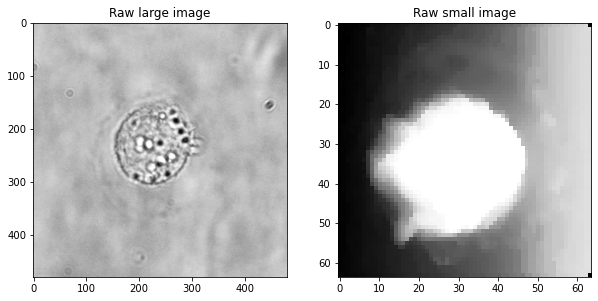

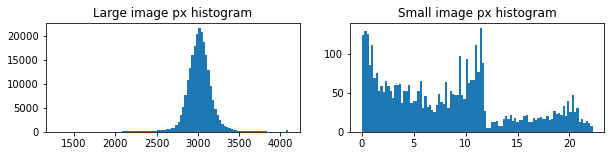

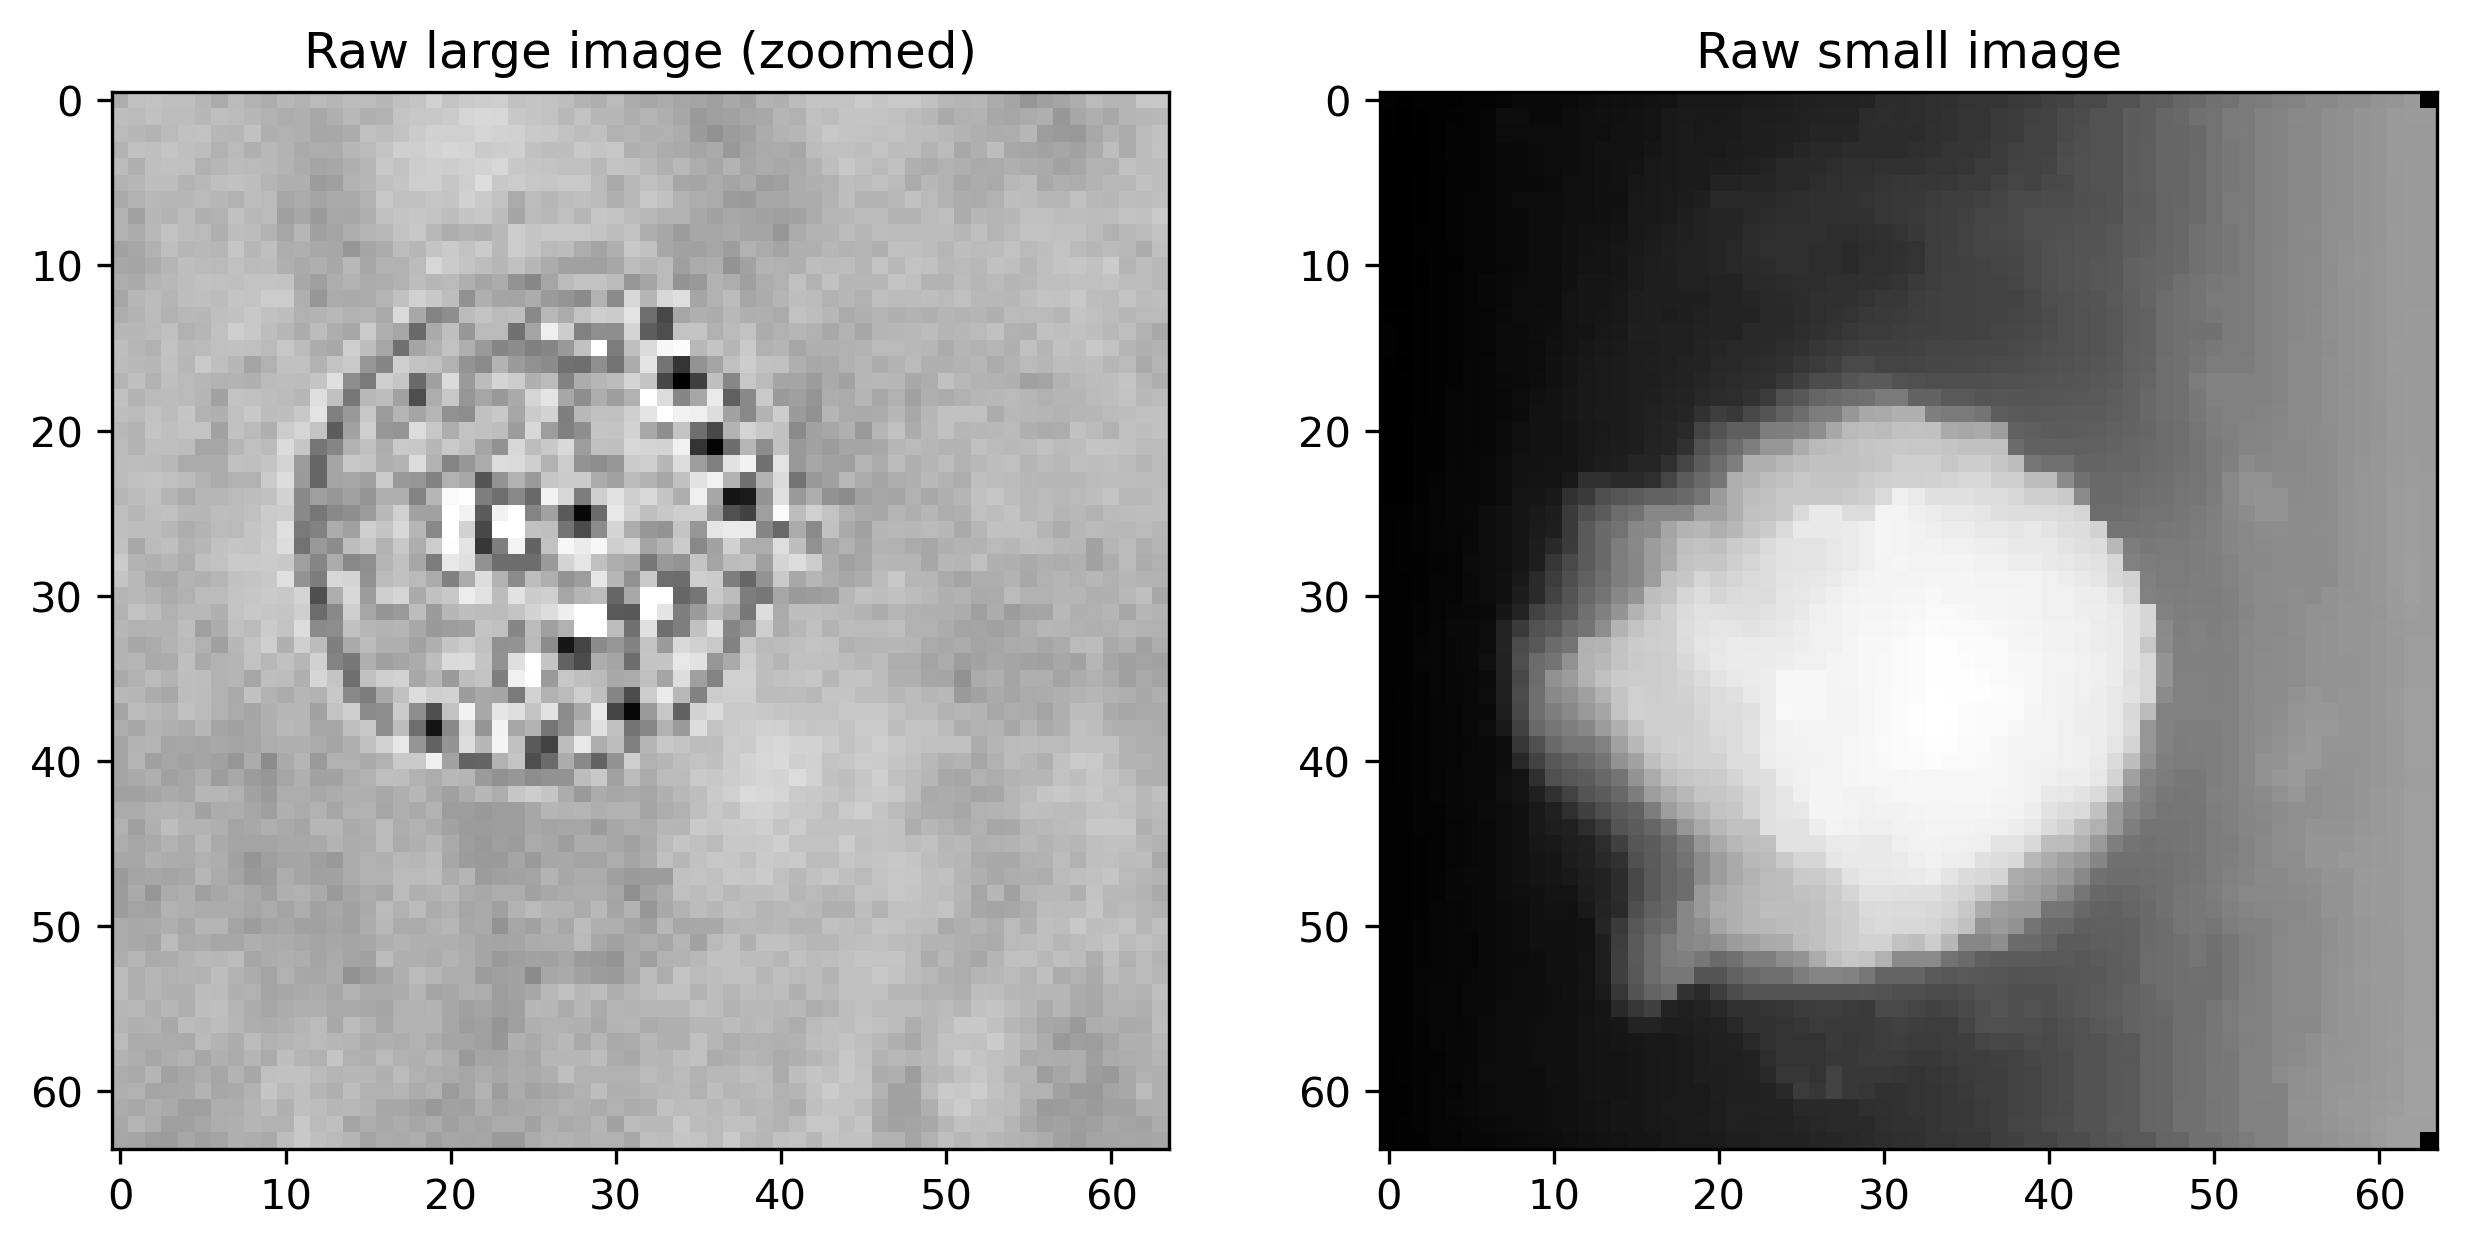

In [10]:
# plotting original images and their histograms
_,axs = plt.subplots(1,2, figsize=(10,20))
axs[0].imshow(im_large_np, cmap='Greys_r')
axs[1].imshow(im_small_np, cmap='Greys_r', vmax=15)
axs[0].set_title('Raw large image')
axs[1].set_title('Raw small image')

_,axs = plt.subplots(1,2, figsize=(10,2))
axs[0].hist(im_large_np.flatten(), 100)
axs[1].hist(im_small_np.flatten(), 100);
axs[0].set_title('Large image px histogram')
axs[1].set_title('Small image px histogram')

_,axs = plt.subplots(1,2, figsize=(10,20), dpi=300)
axs[0].imshow(im_large_np[100:(100+64*resc_rat):resc_rat, 100:(100+64*resc_rat):resc_rat], cmap='Greys_r')
axs[1].imshow(im_small_np, cmap='Greys_r')
axs[0].set_title('Raw large image (zoomed)')
axs[1].set_title('Raw small image')

### Preprocessing large image

Text(0.5, 1.0, 'Truncated px histogram based on percentile threshold')

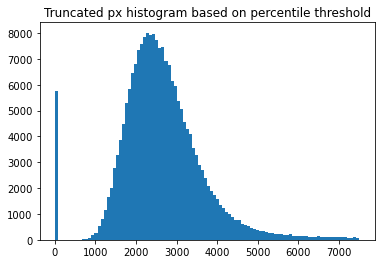

In [11]:
var = local_variance_filter(im_large_np, radius=var_filt_radius)
perc = np.percentile(var, perc_threshold)

var_thr = var.copy()
var_thr[var_thr < perc] = 0
var_thr[var_thr >= perc] = 1

plt.hist(var.flatten()[var.flatten()<perc], 100);
plt.title('Truncated px histogram based on percentile threshold')

Text(0.5, 1.0, 'Binarised staurated variance')

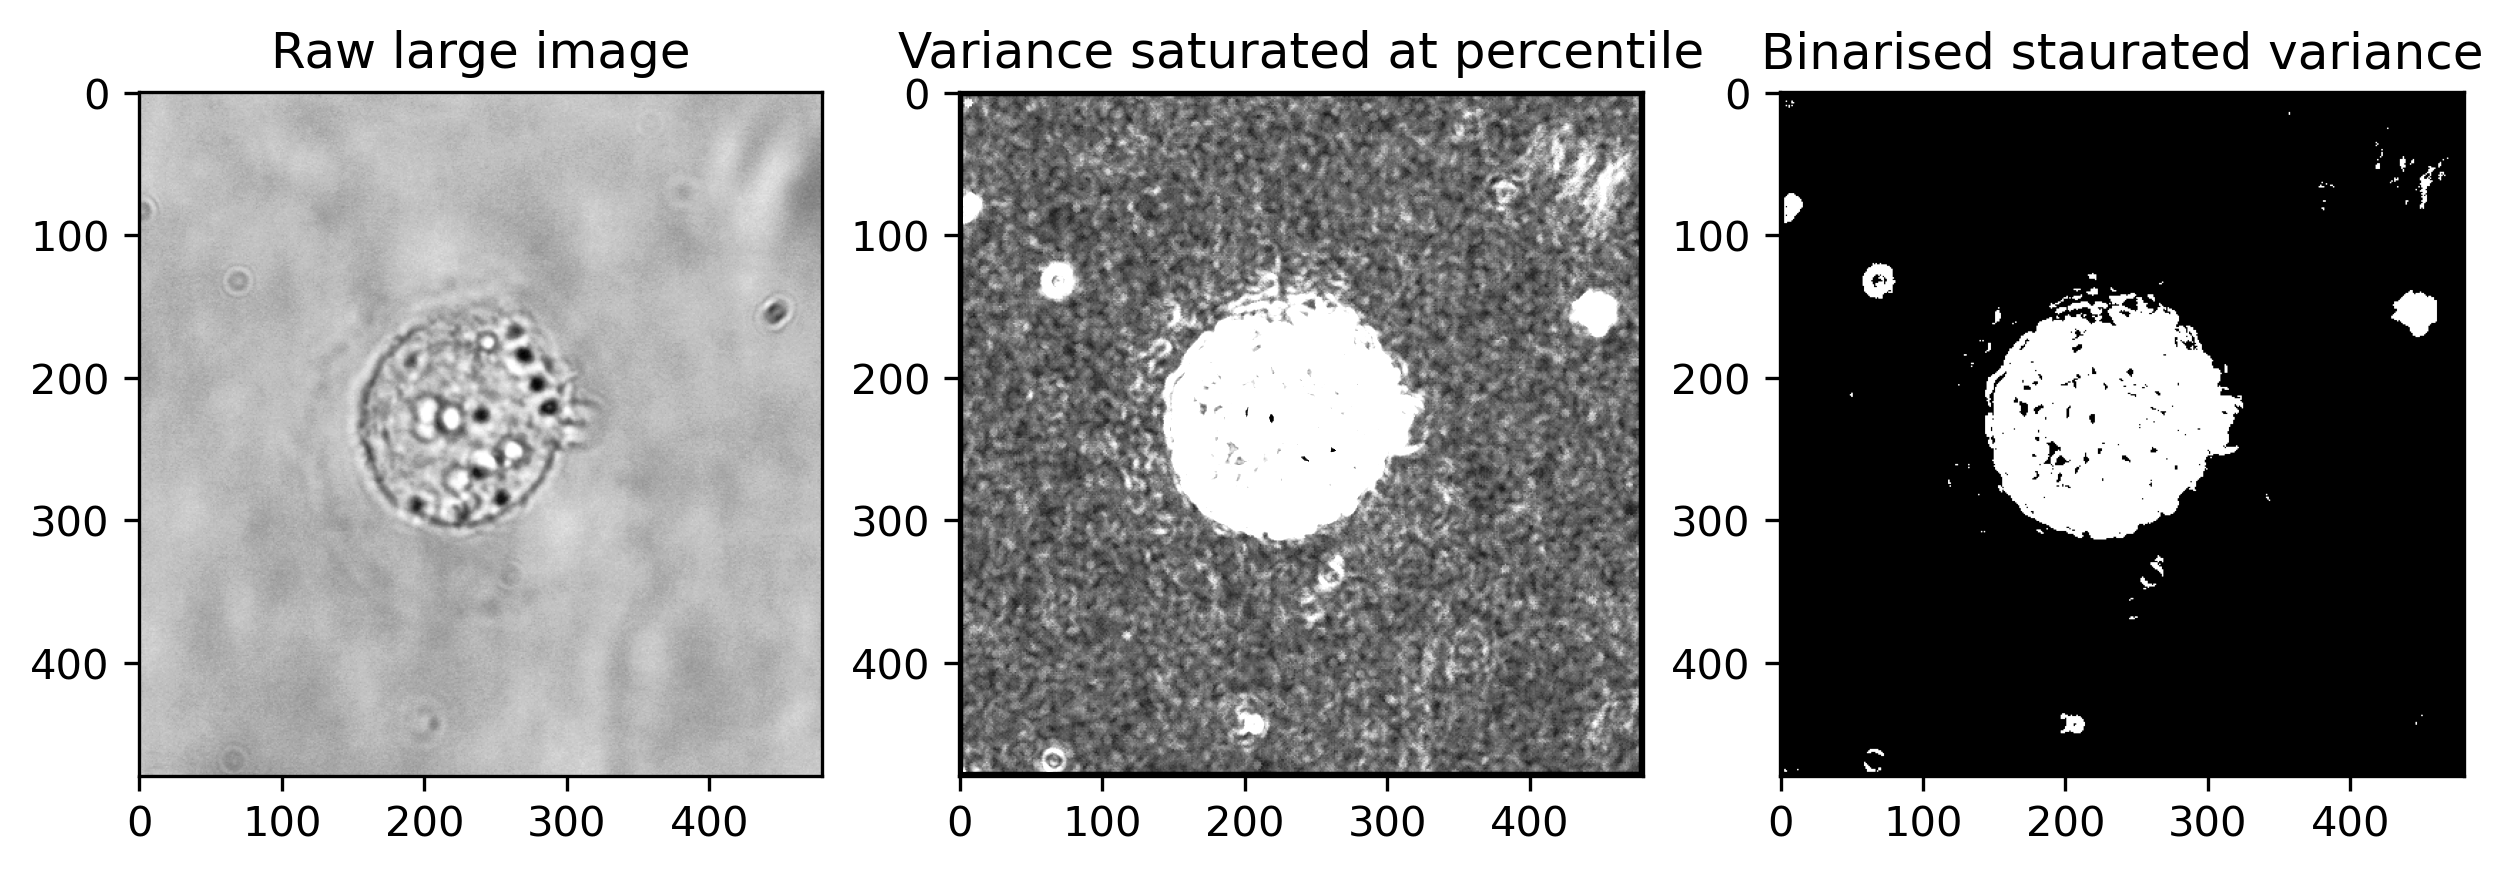

In [12]:
_,axs = plt.subplots(1,3, figsize=(10,20), dpi=300)
axs[0].imshow(im_large_np, cmap='Greys_r')
axs[1].imshow(var, cmap='Greys_r', vmin=0, vmax=perc)
axs[2].imshow(var_thr, cmap='Greys_r')

axs[0].set_title('Raw large image')
axs[1].set_title('Variance saturated at percentile')
axs[2].set_title('Binarised staurated variance')


### Resizing images to match pixels

Text(0.5, 1.0, 'Binarised staurated variance (downsampled)')

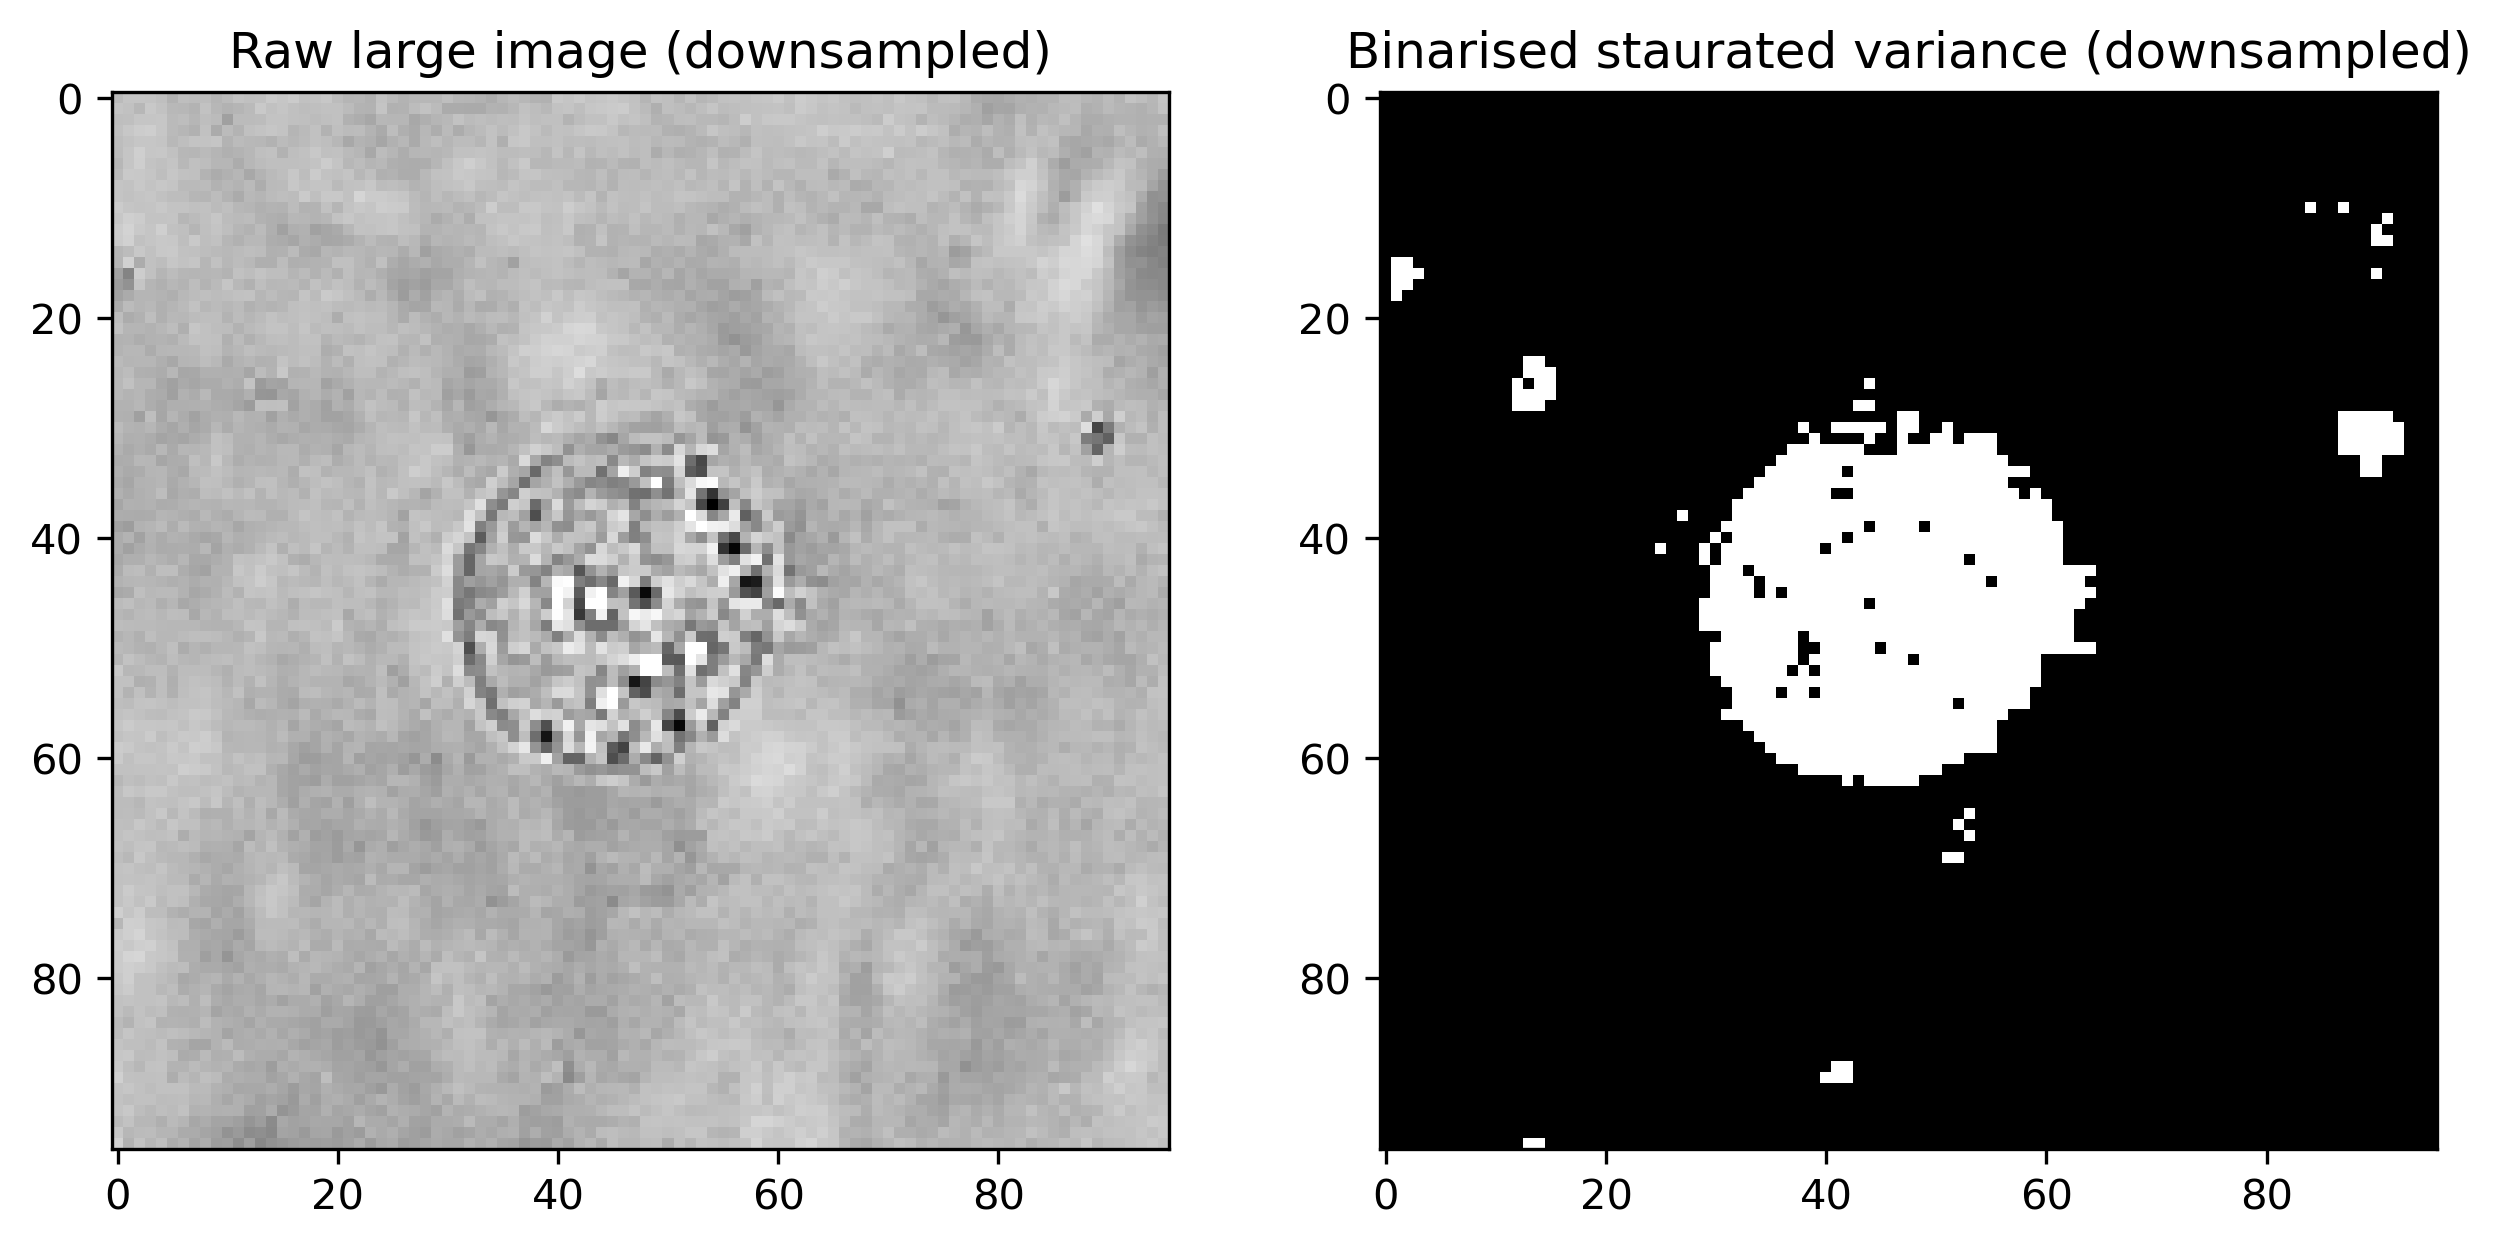

In [13]:
var_thr_downs = var_thr[::resc_rat,::resc_rat]
im_orig_downs = im_large_np[::resc_rat,::resc_rat]

_,axs = plt.subplots(1,2, figsize=(10,20), dpi=300)
axs[0].imshow(im_orig_downs, cmap='Greys_r')
axs[1].imshow(var_thr_downs, cmap='Greys_r')

axs[0].set_title('Raw large image (downsampled)')
axs[1].set_title('Binarised staurated variance (downsampled)')


### Trying cross-correlation

In [28]:

%timeit distance = distance_two_images(var_thr_downs, im_small_np)
res = position_of_min(distance)

54.7 ms ± 6.78 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
the minimum distance is:  393753.1751263994
Tuple of arrays returned :  (array([10], dtype=int64), array([16], dtype=int64))


Text(0.5, 1.0, 'Optimal shift of small image')

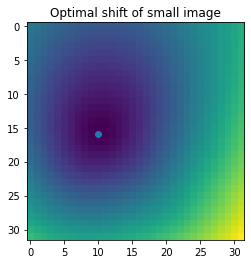

In [15]:
plt.imshow(distance.T)
plt.scatter(res[0][0], res[1][0])
plt.title('Optimal shift of small image')

Text(0.5, 1.0, 'Overlay of small image and large image')

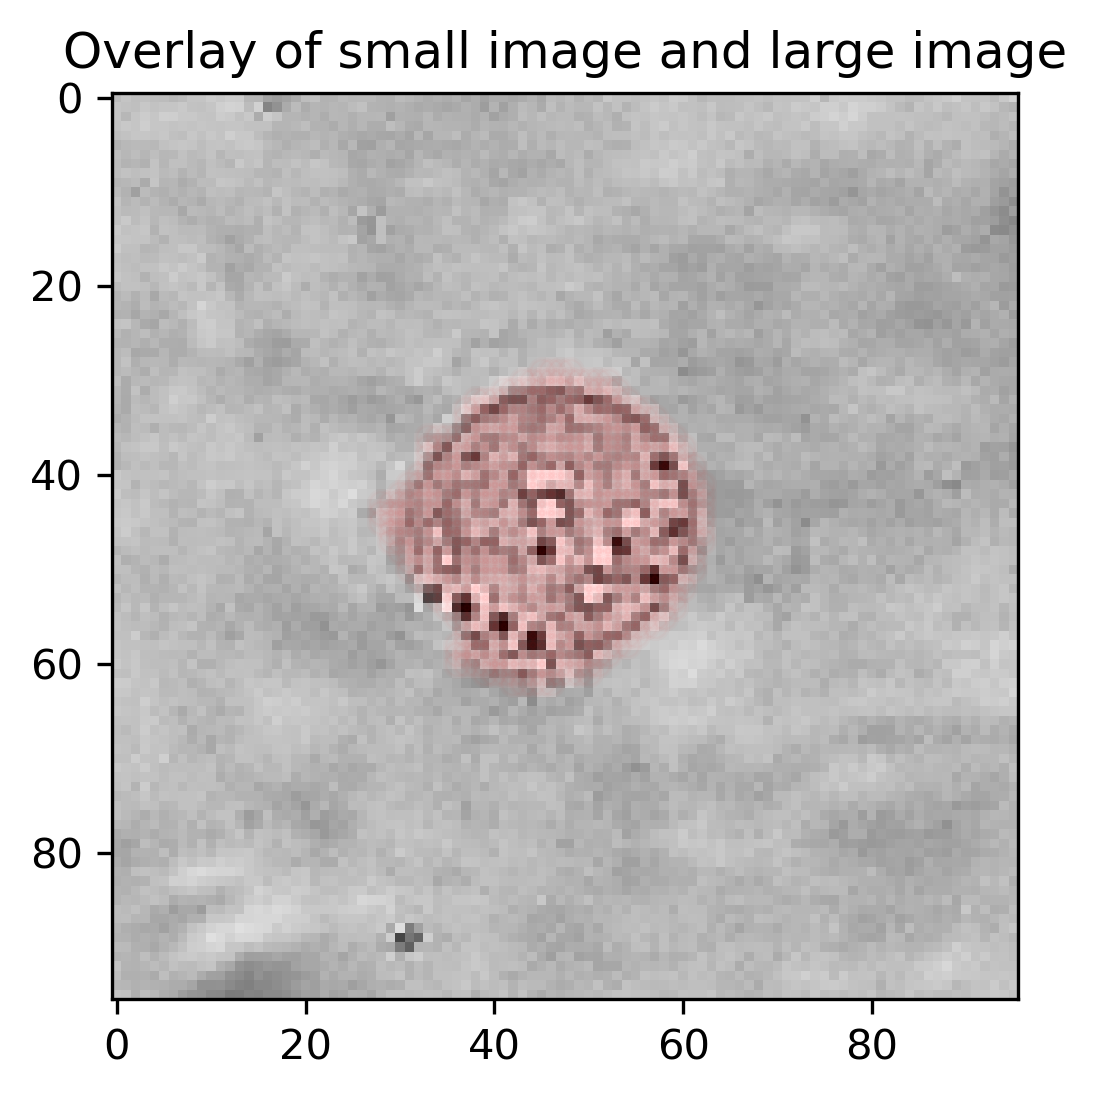

In [16]:
nonzero = np.where(im_small_np > thr_overlay_vis) # only for visualisation

plt.figure(dpi=300)
plt.imshow(im_orig_downs.T, cmap='Greys_r')
plt.scatter(res[1][0]+nonzero[1], res[0][0]+nonzero[0], alpha=0.02, c='red')
plt.title('Overlay of small image and large image')

## Scipy cross-correlation

In [22]:
from scipy import signal
def max_cross_corr(im1,im2): #im1 bigger than im2
    C=signal.correlate(im1,im2) #compute cross correlation
    x=np.where(C==np.max(C))[0]-(im2.shape[0]-1)
    y=np.where(C==np.max(C))[1]-(im2.shape[1]-1)
    return x,y #return where im2 should be put in im1

In [29]:
%timeit x, y = max_cross_corr(var_thr_downs, im_small_np)

print(f'x:{x[0]}, y:{y[0]}')

2.37 ms ± 101 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
x:10, y:16


### Cross-correlation with upsampling

In [17]:
# cv2.resize(im_small_np, )
